### Import bibliotek

In [89]:
#!pip install ccxt
import ccxt
import pandas as pd
import numpy as np
#!pip install ta
import ta
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt

### Funkcje i ustawienia

In [88]:
# Initialize the exchange
exchange = ccxt.binance()

# Function to fetch OHLCV data
def fetch_ohlcv(symbol, timeframe='1h', n_frames=10000, since=None):
    dataframe = pd.DataFrame(columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    timediff = exchange.parse8601( datetime.utcnow().isoformat() ) - since
    for i in range(1+n_frames//1000):
        temp_ohlcv = pd.DataFrame(exchange.fetch_ohlcv(symbol, timeframe, since=since+(timediff*i*1000//n_frames), limit=1000),columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        dataframe = pd.concat([dataframe, temp_ohlcv])
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], unit='ms')
    # Add technical indicators
    dataframe['SMA_50'] = ta.trend.SMAIndicator(close=dataframe['close'], window=50).sma_indicator()
    dataframe['SMA_200'] = ta.trend.SMAIndicator(close=dataframe['close'], window=200).sma_indicator()
    dataframe['RSI_14'] = ta.momentum.RSIIndicator(close=dataframe['close'], window=14).rsi()
    bb = ta.volatility.BollingerBands(close=dataframe['close'], window=20, window_dev=2)
    dataframe['BB_High'] = bb.bollinger_hband()
    dataframe['BB_Low'] = bb.bollinger_lband()
    dataframe.set_index('timestamp', inplace=True)
    return dataframe

# Settings
symbols= ['BTC/USDT', 'ETH/USDT', 'DOT/USDT', 'ADA/USDT', 'SOL/USDT']
timeframe = '1h'
n_hours = 25000  # ok. 3 lata
since = exchange.parse8601( (datetime.utcnow() - timedelta(hours=n_hours)).isoformat() )

## **test uczenia i wizualizacji** ##

C:\Users\vdi-student\AppData\Local\Temp\ipykernel_8576\1559733999.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])
C:\Users\vdi-student\AppData\Local\Temp\ipykernel_8576\1559733999.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


Data for BTC/USDT after dropping NaN values:
(9800, 10)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

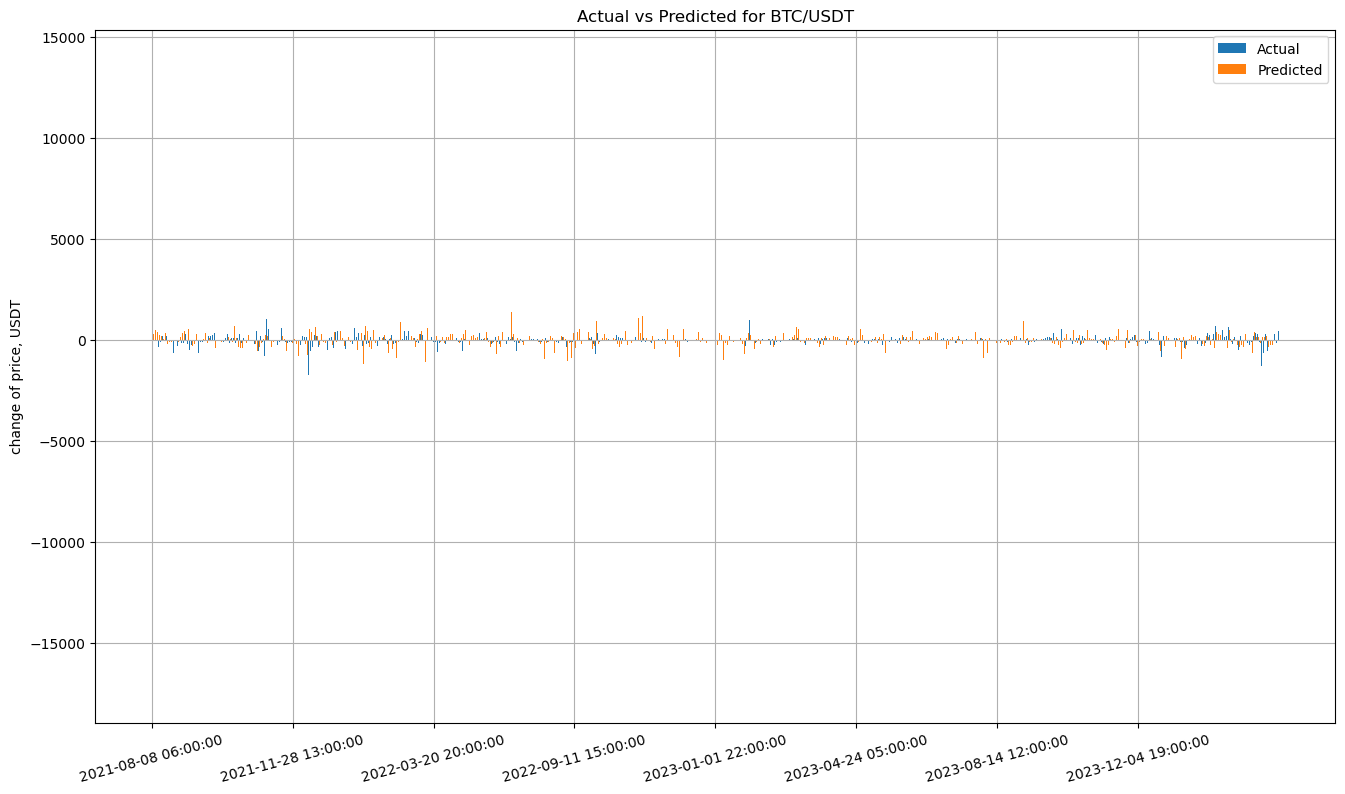

TypeError: bar() missing 1 required positional argument: 'height'

<Figure size 1600x900 with 0 Axes>

In [93]:
dataframe = fetch_ohlcv(symbols[0], timeframe=timeframe, since=since)
    
# convert absolute values to relative values
dataframe = dataframe.diff()

# Prepare data for machine learning
dataframe = dataframe.dropna()  # Drop rows with NaN values

# Check if data is not empty after dropping NaN values
print(f"Data for {symbols[0]} after dropping NaN values:")
print(dataframe.shape)
if dataframe.empty:
    raise ValueError(f"Dataframe for {symbols[0]} is empty after dropping NaN values. Check data fetching and indicator calculation steps.")


model = MLPRegressor(hidden_layer_sizes=(125, 125), max_iter=100, alpha=0.002,learning_rate='adaptive',tol=0.002, learning_rate_init=0.002, random_state=42)
X = dataframe.drop(['close'], axis=1)
y = dataframe['close']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
tscv = TimeSeriesSplit(n_splits=40)
predictions = []
for train_index, test_index in tscv.split(X_scaled):
    X_train = scaler.fit_transform(X.values[train_index])
    X_test = scaler.fit_transform(X.values[test_index])
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions.extend(y_pred)

# Plotting the results
fig, ax = plt.subplots(figsize=(16, 9))
x_temp = np.arange(len(dataframe.index[-len(predictions):]))
w = 0.4
ax.bar(x_temp - w/2, y.iloc[-len(predictions):], width=w, label="Actual")
ax.bar(x_temp + w/2, predictions, width=w, label="Predicted")
ax.set_ylabel("change of price, USDT")
ax.set_xticks(x_temp)
ax.set_xticklabels(dataframe.index[-len(predictions):].astype(str), rotation=15)
plt.locator_params(axis="x", nbins=8)
ax.grid(True)
ax.set_title(f"Actual vs Predicted for {symbols[0]}")
ax.legend()
plt.show()

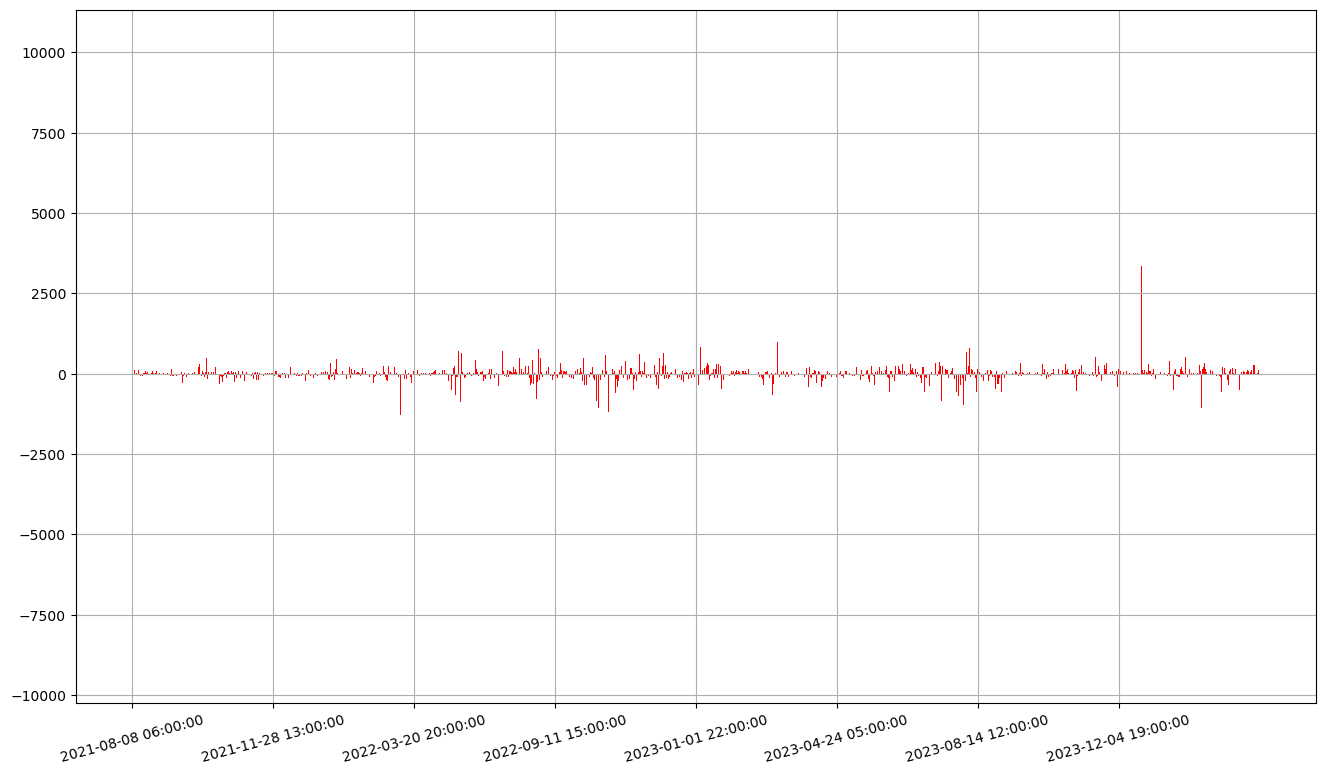

In [102]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(x_temp, y.iloc[-len(predictions):]-predictions, color="red")
ax.set_xticks(x_temp)
ax.set_xticklabels(dataframe.index[-len(predictions):].astype(str), rotation=15)
ax.grid(True)
plt.locator_params(axis="x", nbins=8)
plt.show()

## jakieś przykładowe miary

In [ ]:
# Print & return the R2 score, RSS, MSE and RMSE for the given test data
def compute_metrics( y_test, y_pred_test, model_name, final_metrics):
    metric = []

    r2_test_lr = r2_score(y_test, y_pred_test)
    metric.append(r2_test_lr)


    rss2_lr = np.sum(np.square(y_test - y_pred_test))
    metric.append(rss2_lr)

    mse_test_lr = mean_squared_error(y_test, y_pred_test)
    metric.append(mse_test_lr**0.5)
     
    if VERBOSE:
        print(f'R2 - test: {r2_test_lr}')
        print(f'RSS - test: {rss2_lr}')
        print(f'MSE - test: {mse_test_lr}, RMSE = {math.sqrt(mse_test_lr)}')
    
    final_metrics[f'{model_name}'] = metric
    
    return final_metrics

## **wizualizacja - podział na dane uczące i testowe** ##

C:\Users\vdi-student\AppData\Local\Temp\ipykernel_8576\1559733999.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])
C:\Users\vdi-student\AppData\Local\Temp\ipykernel_8576\1559733999.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, temp_ohlcv])


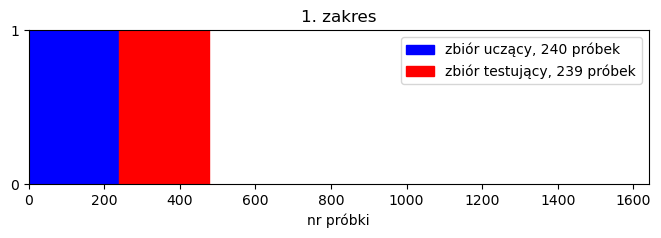

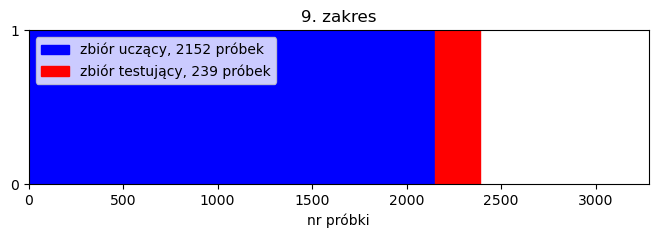

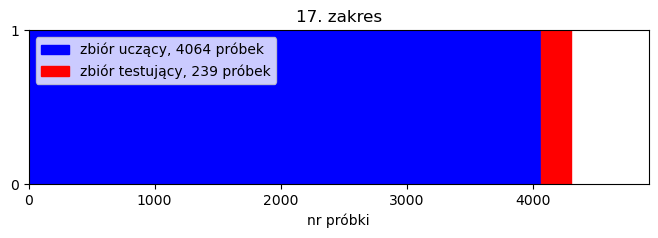

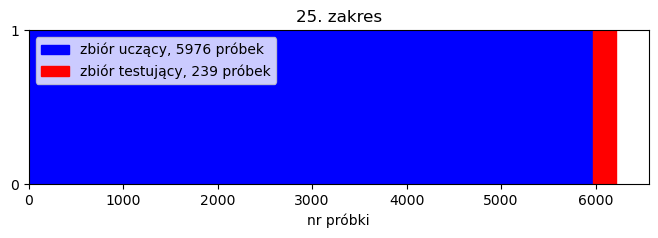

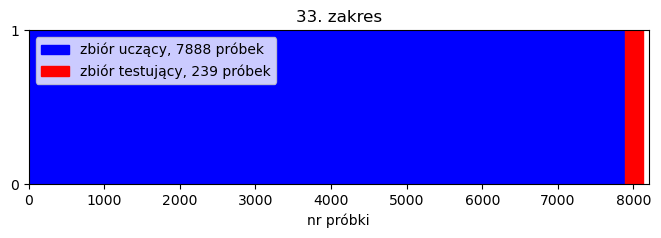

In [92]:
dataframe = fetch_ohlcv(symbols[0], timeframe=timeframe, since=since)
dataframe = dataframe.diff()
dataframe = dataframe.dropna()
X = dataframe.drop(['close'], axis=1)

tscv = TimeSeriesSplit(n_splits=40)
for i, (train_ind, test_ind) in enumerate(tscv.split(X)):
    if (i%8==0):
        fig, ax = plt.subplots(figsize=(8,2))
        ax.set_title(f"{i+1}. zakres")
        ax.axvspan(train_ind[0], test_ind[0], color="b")
        ax.axvspan(test_ind[0], test_ind[-1], color="r")
        ax.set_xlim([0,(8200*(i+8)/40)])
        ax.set_xlabel("nr próbki")
        ax.set_yticks([0,1])
        ax.legend([f"zbiór uczący, {len(train_ind)} próbek", f"zbiór testujący, {len(test_ind)} próbek"])
        plt.show

### Uczenie modeli

Data for BTC/USDT after dropping NaN values:
(300, 10)
Features (X) and target (y):
(300, 9) (300,)
Mean squared error for BTC/USDT: 20279.93


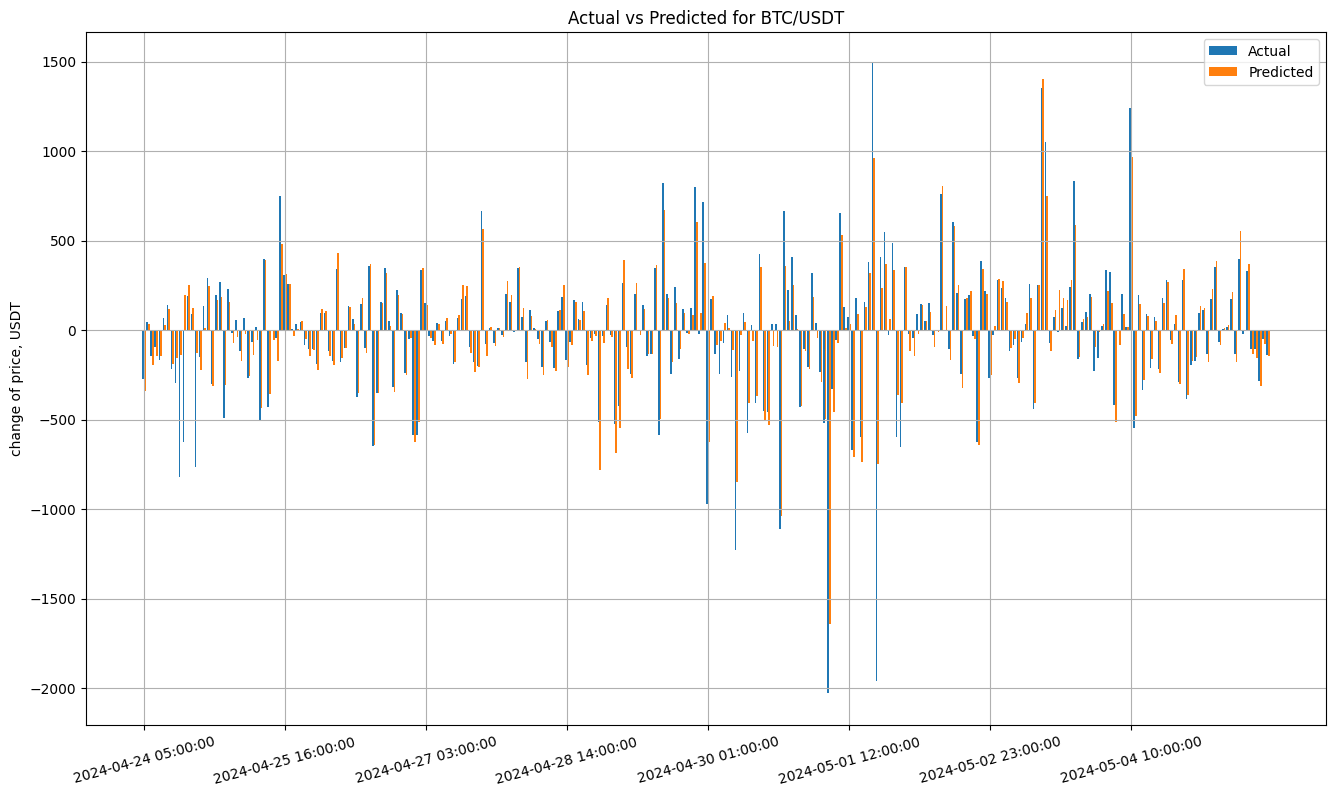

Data for ETH/USDT after dropping NaN values:
(300, 10)
Features (X) and target (y):
(300, 9) (300,)
Mean squared error for ETH/USDT: 34.51


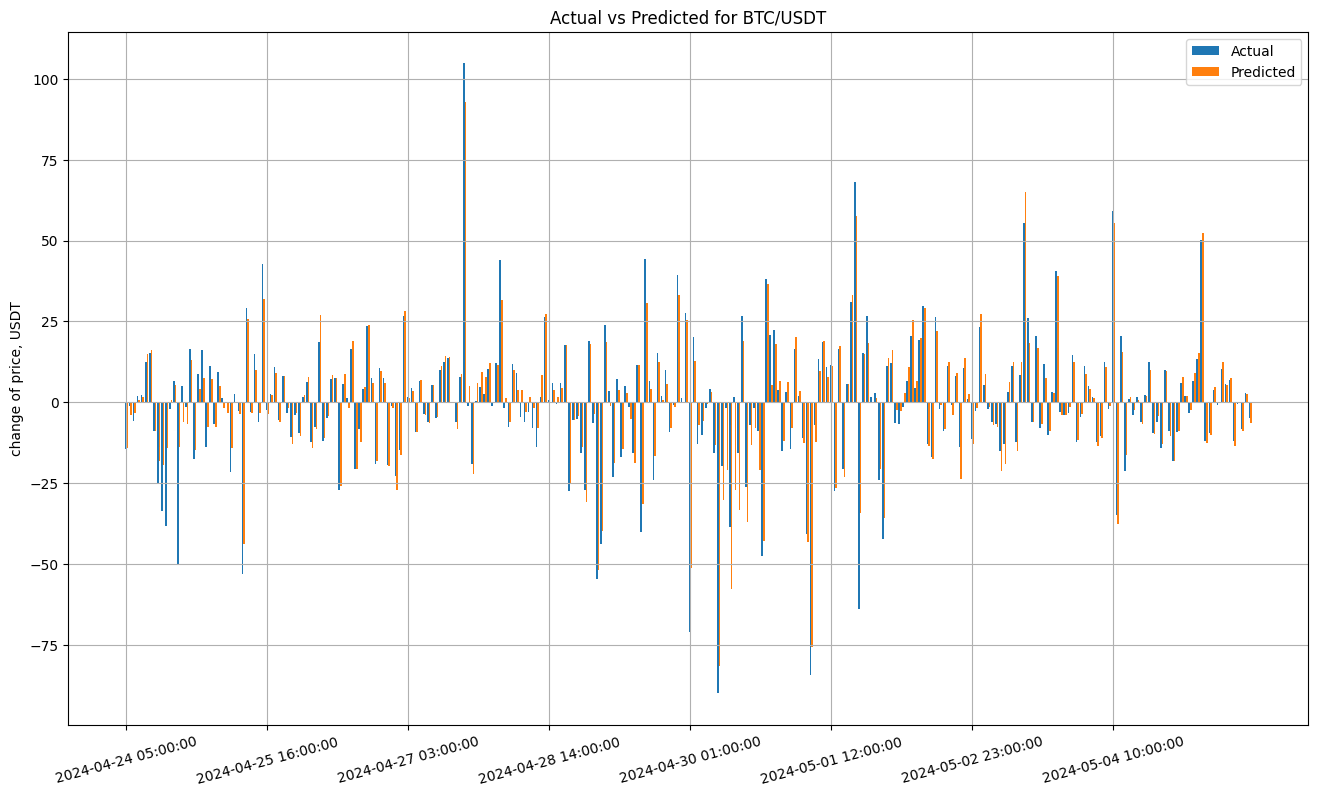

Data for DOT/USDT after dropping NaN values:
(300, 10)
Features (X) and target (y):
(300, 9) (300,)
Mean squared error for DOT/USDT: 0.01


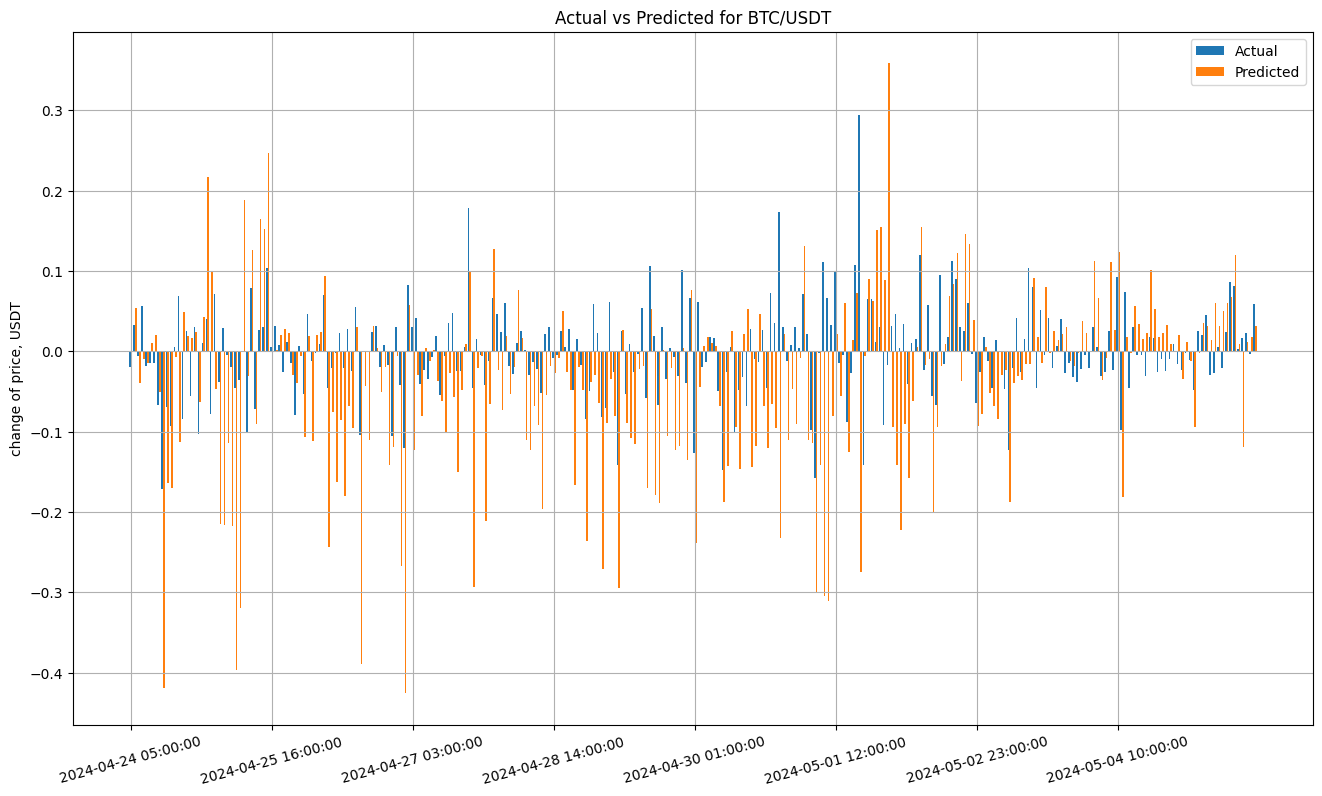

Data for ADA/USDT after dropping NaN values:
(300, 10)
Features (X) and target (y):
(300, 9) (300,)
Mean squared error for ADA/USDT: 0.01


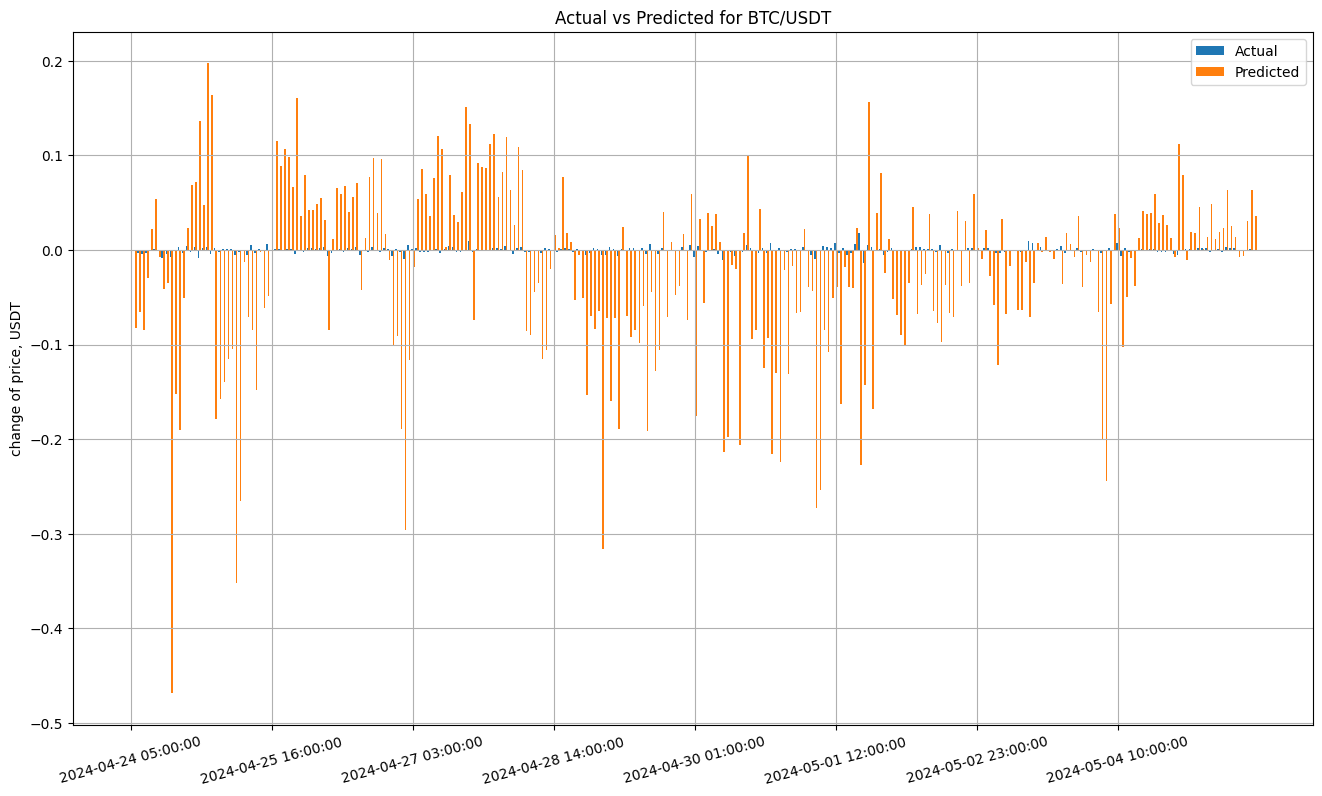

Data for SOL/USDT after dropping NaN values:
(300, 10)
Features (X) and target (y):
(300, 9) (300,)
Mean squared error for SOL/USDT: 0.19


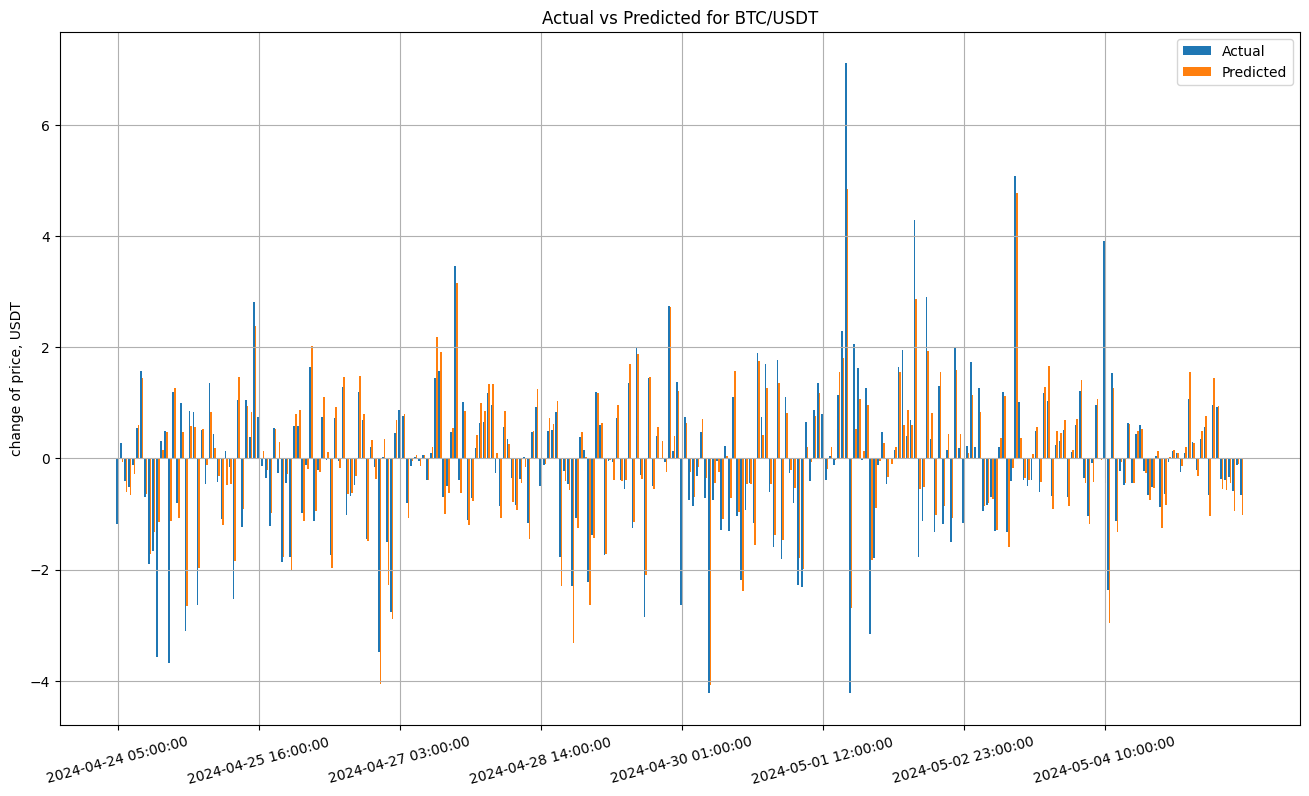

In [100]:
# Container for predictions
all_predictions = {}

for symbol in symbols:   
    # Fetch data
    dataframe = fetch_ohlcv(symbol, timeframe=timeframe, since=since)
    
    # convert absolute values to differences between them
    dataframe = dataframe.diff()
    
    # Prepare data for machine learning
    dataframe = dataframe.dropna()  # Drop rows with NaN values

    # Check if data is not empty after dropping NaN values
    print(f"Data for {symbol} after dropping NaN values:")
    print(dataframe.shape)
    if dataframe.empty:
        raise ValueError(f"Dataframe for {symbol} is empty after dropping NaN values. Check data fetching and indicator calculation steps.")

    X = dataframe.drop(['close'], axis=1)
    y = dataframe['close']

    # Check if features and target are correctly separated
    print("Features (X) and target (y):")
    print(X.shape, y.shape)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Model and cross-validation setup
    model = MLPRegressor(hidden_layer_sizes=(125, 125), max_iter=20000, alpha=0.002,learning_rate='adaptive',tol=0.002, learning_rate_init=0.002, random_state=42)
    n_samp=40
    tscv = TimeSeriesSplit(n_splits=n_samp)
    
    # Training and prediction
    predictions = []
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)        
        predictions.extend(y_pred)

    # Store predictions
    all_predictions[symbol] = predictions

    # Evaluate the model
    mse = mean_squared_error(y.iloc[-len(predictions):], predictions)
    print(f"Mean squared error for {symbol}: {mse:.2f}")

    # Plotting the results
    fig, ax = plt.subplots(figsize=(16, 9))
    x_temp = np.arange(len(dataframe.index[-len(predictions):]))
    w = 0.4
    ax.bar(x_temp - w/2, y.iloc[-len(predictions):], width=w, label="Actual")
    ax.bar(x_temp + w/2, predictions, width=w, label="Predicted")
    ax.set_ylabel("change of price, USDT")
    ax.set_xticks(x_temp)
    ax.set_xticklabels(dataframe.index[-len(predictions):].astype(str), rotation=15)
    plt.locator_params(axis="x", nbins=8)
    ax.grid(True)
    ax.set_title(f"Actual vs Predicted for {symbols[0]}")
    ax.legend()
    plt.show()

In [38]:
print(all_predictions)

NameError: name 'all_predictions' is not defined

## macierze korelacji

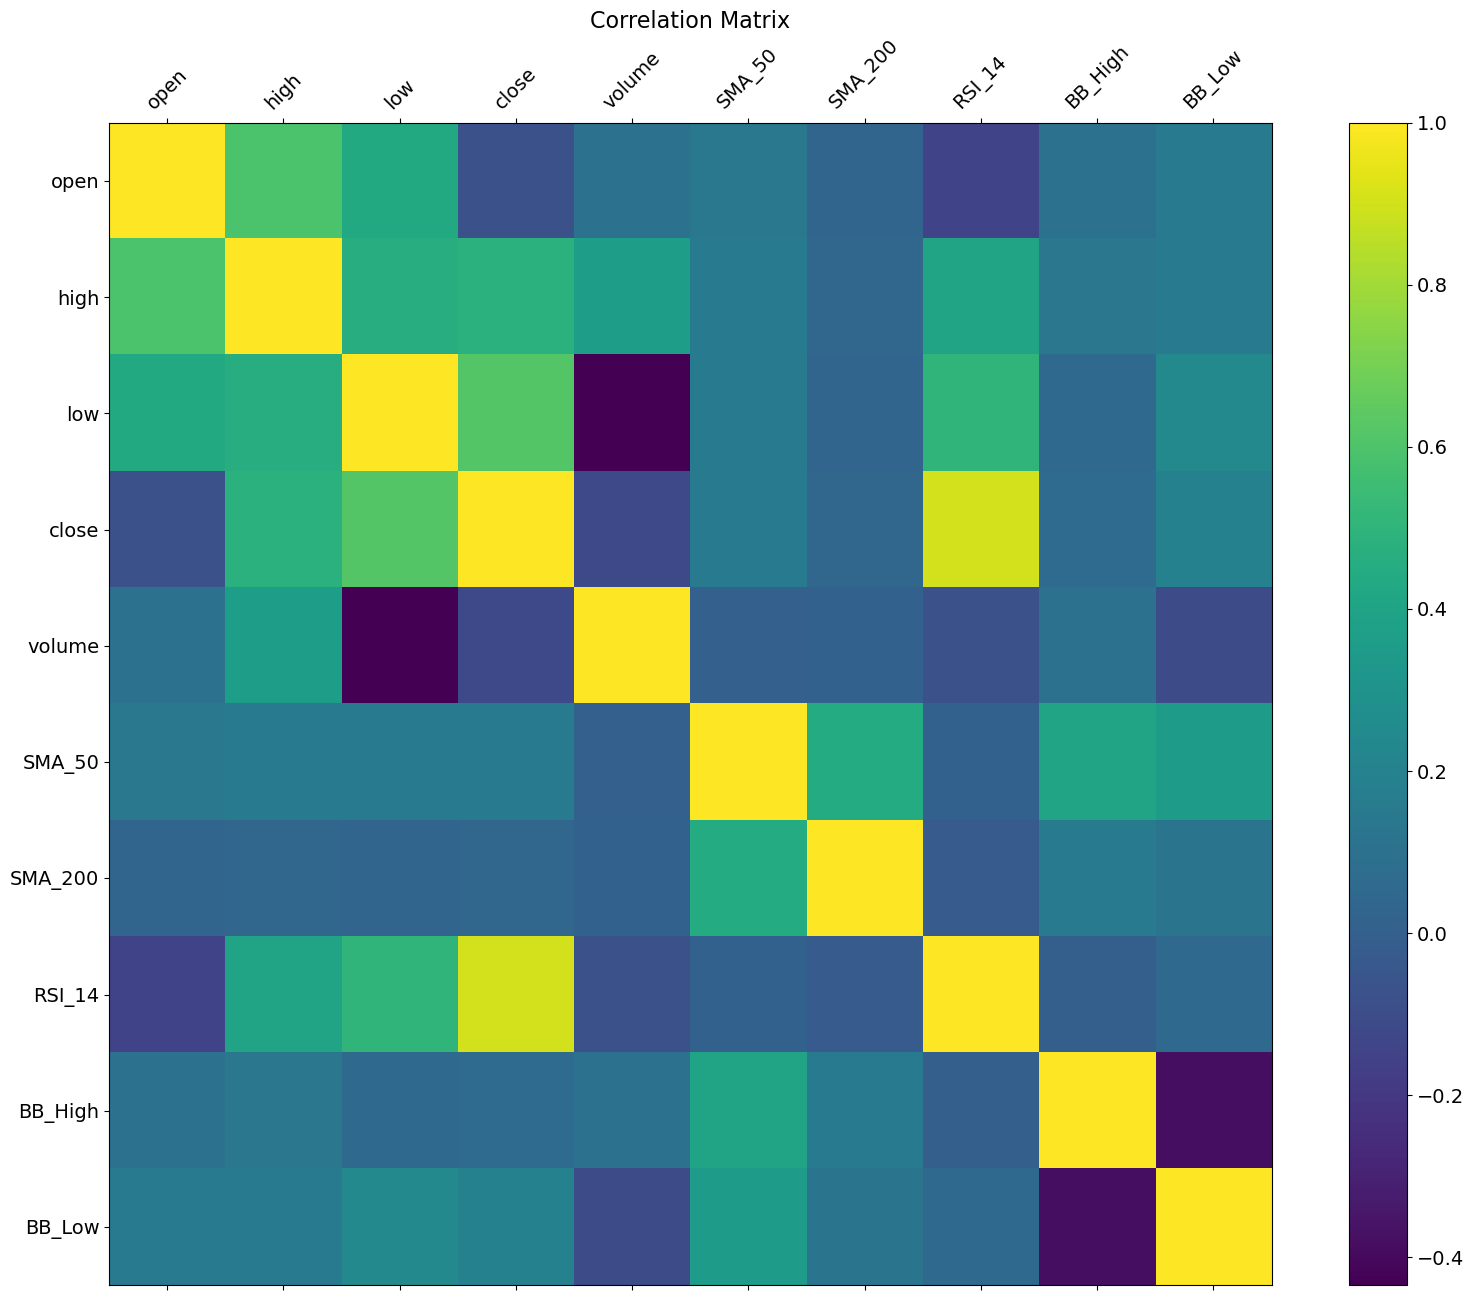

In [36]:
def plot_correlation(df):
    f = plt.figure(figsize=(20, 15))
    ax = plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #ax.set_ylim([0,2])
    plt.title('Correlation Matrix', fontsize=16);
    
corr=dataframe.corr()
plot_correlation(dataframe)

In [35]:
corr.style.background_gradient(cmap='coolwarm')

,open,high,low,close,volume,SMA_50,SMA_200,RSI_14,BB_High,BB_Low
open,1.000000,0.592384,0.435977,-0.077305,0.108458,0.140167,0.034632,-0.145266,0.107259,0.151225
high,0.592384,1.000000,0.461044,0.484140,0.361588,0.157675,0.040891,0.401368,0.133584,0.151230
low,0.435977,0.461044,1.000000,0.615343,-0.434277,0.159871,0.033238,0.506137,0.058442,0.242050
close,-0.077305,0.484140,0.615343,1.000000,-0.118976,0.155897,0.040977,0.902630,0.066618,0.198750
volume,0.108458,0.361588,-0.434277,-0.118976,1.000000,0.007762,0.012049,-0.079482,0.108350,-0.102544
SMA_50,0.140167,0.157675,0.159871,0.155897,0.007762,1.000000,0.448897,0.012360,0.400764,0.361146
SMA_200,0.034632,0.040891,0.033238,0.040977,0.012049,0.448897,1.000000,-0.022936,0.161281,0.117177
RSI_14,-0.145266,0.401368,0.506137,0.902630,-0.079482,0.012360,-0.022936,1.000000,0.001154,0.057754
BB_High,0.107259,0.133584,0.058442,0.066618,0.108350,0.400764,0.161281,0.001154,1.000000,-0.379635
BB_Low,0.151225,0.151230,0.242050,0.198750,-0.102544,0.361146,0.117177,0.057754,-0.379635,1.000000
